In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import itertools
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [3]:
import classifier_utils as utils

In [95]:
import cnn_classifier
reload(cnn_classifier)

<module 'cnn_classifier' from 'cnn_classifier.py'>

# Get Dataset

In [101]:
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]

train, test = utils.get_augmented_dataset_divided_per_image(categories)

Dropped 1559 patches because too close to image border
Dropped 523 patches because too close to image border


In [102]:
for (k, v) in train.iteritems():
    print "train", k, v.shape
for (k, v) in test.iteritems():
    print "test", k, v.shape

train hsv_factors (60000, 3)
train deltas (60000, 2)
train patches (60000, 27, 27, 3)
train rots (60000,)
train labels (60000, 4)
train flips (60000,)
train centres (60000, 2)
train img_ids (60000,)
test img_ids (4593,)
test labels (4593, 4)
test patches (4593, 27, 27, 3)
test centres (4593, 2)


In [103]:
# Sanity-check that the test and train data come from different images
test_img_ids = set(test['img_ids'])
train_img_ids = set(train['img_ids'])
print "Train:", sorted(train_img_ids)
print "Test:", sorted(test_img_ids)
print "Intersection:", sorted(train_img_ids.intersection(test_img_ids))

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 40, 41, 42, 43, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 66, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99]
Test: [9, 12, 21, 25, 36, 37, 39, 44, 46, 47, 58, 64, 65, 67, 70, 81, 83, 87, 88, 96]
Intersection: []


In [104]:
# DELETE ME
# Temp for spot check
(all_imgs, _, _) = utils.get_dataset(100, categories)

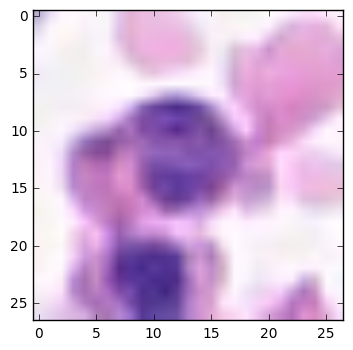

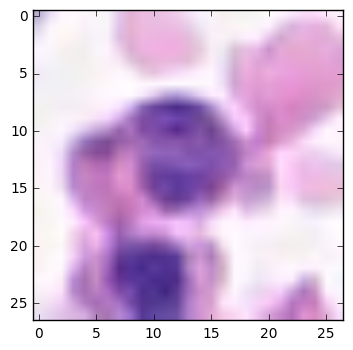

In [105]:
# DELETE ME
# Spot check
i = 420
plt.figure()
plt.imshow(test['patches'][i])
(x, y) = test['centres'][i]
img_id = test['img_ids'][i]
img = all_imgs[img_id]
plt.figure()
plt.imshow(img[y-13:y+14,x-13:x+14])

# Train a Softmax CNN Model

In [106]:
try:
    sess.close()
except:
    pass # sess doesn't exist yet!

tf.reset_default_graph()
sess = tf.InteractiveSession()

patch_model = cnn_classifier.SoftmaxCNNModel()

In [111]:
num_epochs = 20
batch_size = 100
tr_loss, tst_loss = patch_model.train_loop(sess,
                                           train['patches']*255,
                                           train['labels'],
                                           test['patches']*255,
                                           test['labels'],
                                           num_epochs,
                                           batch_size)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0, step 0, training loss 1.386460, test_loss 1.387063, accuracy = 0.207272/0.250163, f1 = nan
Epoch 0, step 25, training loss 1.386188, test_loss 1.387260, accuracy = 0.230786/0.259525, f1 = nan
Epoch 0, step 50, training loss 1.384773, test_loss 1.387609, accuracy = 0.238189/0.249946, f1 = nan
Epoch 0, step 75, training loss 1.386149, test_loss 1.388587, accuracy = 0.238842/0.251034, f1 = nan
Epoch 0, step 100, training loss 1.385368, test_loss 1.388743, accuracy = 0.241890/0.266057, f1 = nan
Epoch 0, step 125, training loss 1.384659, test_loss 1.388955, accuracy = 0.204224/0.246897, f1 = nan
Epoch 0, step 150, training loss 1.385288, test_loss 1.390291, accuracy = 0.209885/0.249075, f1 = nan
Epoch 0, step 175, training loss 1.384866, test_loss 1.389790, accuracy = 0.223166/0.249728, f1 = nan
Epoch 0, step 200, training loss 1.382402, test_loss 1.388770, accuracy = 0.224907/0.250163, f1 = nan
Epoch 0, step

In [112]:
# Save the model
saver = tf.train.Saver(write_version=1)
save_path = saver.save(sess, "context_models/patch_models/v2/model.ckpt",)
print "Saved to:", save_path

Saved to: context_models/patch_models/v2/model.ckpt


# Get Non-Augmented Dataset

In [116]:
(train_vanilla, _) = utils.get_dataset_divided_per_image(categories)

Dropped 1559 patches because too close to image border
Dropped 523 patches because too close to image border


# Derp Around

In [ ]:
(train_vanilla, test_vanilla) = utils.get_dataset_divided_per_image(categories)

In [115]:
import classifier_utils as utils
reload(utils)

<module 'classifier_utils' from 'classifier_utils.py'>

In [119]:
for (k, v) in train_vanilla.iteritems():
    print "train", k, v.shape

train img_ids (15769,)
train labels (15769, 4)
train patches (15769, 27, 27, 3)
train centres (15769, 2)


1917
[1 0 0 0]
[1 0 0 0]


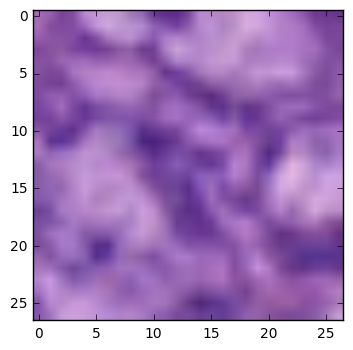

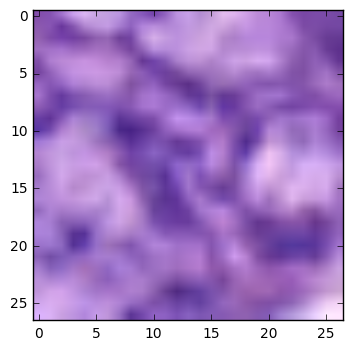

In [137]:
target = 1010
i = train['img_ids'][target]
c = train['centres'][target]
for ii in xrange(len(train_vanilla['img_ids'])):
    if train_vanilla['img_ids'][ii] == i and np.all(np.equal(train_vanilla['centres'][ii], c)):
        break
print ii
plt.imshow(train['patches'][target])
plt.figure()
plt.imshow(train_vanilla['patches'][ii])
print train['labels'][target]
print train_vanilla['labels'][ii]

# Compute Probability Weight Neighbourhoods

In [206]:
import context_classifier
reload(context_classifier)

<module 'context_classifier' from 'context_classifier.pyc'>

In [207]:
test['probabilities'], test['weight_neighbourhoods'] = \
    context_classifier.compute_probability_neighbourhoods(sess, test, patch_model)
train_vanilla['probabilities'], train_vanilla['weight_neighbourhoods'] = \
    context_classifier.compute_probability_neighbourhoods(sess, train_vanilla, patch_model)